<a href="https://colab.research.google.com/github/wellmej/DataScienceUseCases/blob/main/Case4_My_Operations_Department_Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=15eGnAbma5Q_j9CZZKi46Gh3-EpgSWYOV"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1. Classifying disease using Deep Learning 
  </td></tr>
</table>


![alt text](https://drive.google.com/uc?id=19BuQ5m0xZWC7vQN4jX9lukmJ4aE0EkL8)

![alt text](https://drive.google.com/uc?id=10tbeSkGZ0xdHtqTGhYwHhb9PPURw0BfD)

# TASK #2: IMPORT LIBRARIES AND DATASET

In [1]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# You will need to mount your drive using the following commands:
# For more information regarding mounting, please check this out: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory
# 
# This google.colab mount command will give you access to your own google storage
# area. You can maintain it via your goggle account. Signon to your account, select Drive from the box of circles icon

from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

# You have to include the full link to the csv file containing your dataset
#C:\Users\jrwel\Documents\Udemy\Data Science Real-World Case Studies\Data\Case4
#X_Ray_Directory = 'C:/Users/jrwel/Documents/Udemy/Data Science Real-World Case Studies/Data/Case4/Dataset'
#employee_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Science Case Studies/Case1/Human_Resources.csv')
#employee_df = pd.read_csv('C:/Users/jrwel/Documents/Udemy/Data Science Real-World Case Studies/Data/Case1/Human_Resource.csv')
#employee_df = pd.read_csv(hr_file)
#employee_df


Mounted at /content/drive


In [3]:
# Specify training data directory
#X_Ray_Directory = '/content/drive/Users/jrwel/Documents/Udemy/Data Science Real-World Case Studies/Data/Case4/Dataset'
X_Ray_Directory = '/content/drive/MyDrive/Colab Notebooks/Data Science Case Studies/Case4/Dataset'
X_Ray_Validation = '/content/drive/MyDrive/Colab Notebooks/Data Science Case Studies/Case4/Dataset'
#X_Ray_Directory = '/content/drive/My Drive/Colab Notebook/Chest_X_Ray/train'

In [4]:
# List the folders in the directory
os.listdir(X_Ray_Directory)

['3', '2', '0', '1']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [6]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size=40, directory=X_Ray_Directory,shuffle=True, target_size=(256, 256), class_mode = 'categorical', subset='training')


Found 428 images belonging to 4 classes.


In [7]:
#----------------------------------------------------------------------------------------
#  Change to 'validation' subset
#----------------------------------------------------------------------------------------
validation_generator = image_generator.flow_from_directory(batch_size=40, directory=X_Ray_Directory,shuffle=True, target_size=(256, 256), class_mode = 'categorical', subset='validation')

Found 104 images belonging to 4 classes.


In [8]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [9]:
train_images.shape # Color photos, so 40 images of 256 by 256 pixels for 3 color intensities (red, blue, green) 

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
#------------------------------------------
# 1,0,0,0 = Healthy Patient
# 0,1,0,0 = Covid-19 Patient
# 0,0,1,0 = Bacterial Pneumonia
# 0,0,0,1 = Viral Pneumonia
#
#  Assumes only one disease per patient
#------------------------------------------

train_labels

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]],

In [12]:
# labels Translator 
label_names = {0: '0-Covid-19', 1: '1-Normal', 2: '2-Viral Pneumonia', 3: '3-Bacterial Pneumonia'}

# TASK #3: VISUALIZE DATASET

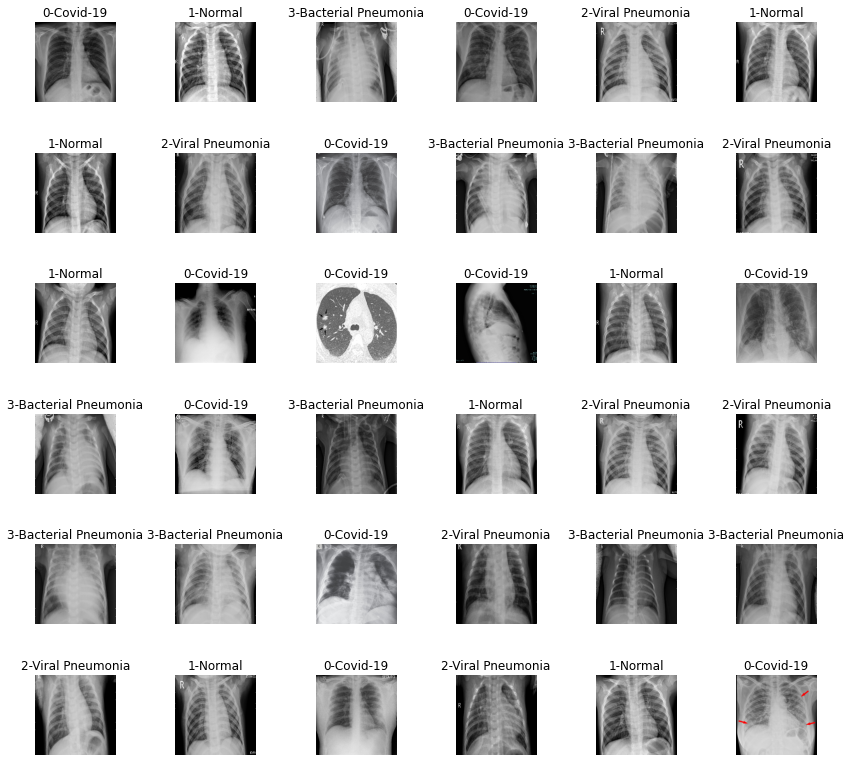

In [13]:
#----------------------------------------------------------------------
#  Create grid of 6 x 6 images (36 totsl) to display image and the
#  the label of the figure
#----------------------------------------------------------------------
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (14,14))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace= 0.75)

In [14]:
np.argmax(train_labels[1])

1

# TASK #4: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS

![alt text](https://drive.google.com/uc?id=176TJGdJtNZmX4J5QyeI8W_YS5f1gg5VS)

![alt text](https://drive.google.com/uc?id=1340UvqbXc-sy6cIuVg7ZbOwcga2JxfkP)

![alt text](https://drive.google.com/uc?id=1hngDlUf9JnwUhPII-Ah7KTtcvoeTI9m8)

![alt text](https://drive.google.com/uc?id=1nt8iX7H2LEhaWgGCi_NIb05DMQEoJVfI)

# TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND TRANSFER LEARNING

![alt text](https://drive.google.com/uc?id=1Wnti2DSmA2qMRsgkD7Z_MJkmed0bJZTN)

![alt text](https://drive.google.com/uc?id=1Chdq0gdnHGYDDb50pMMtcTOZMr0u37Iz)

![alt text](https://drive.google.com/uc?id=14niGb232X6l8OD1dMT4a_u3fjh_jKuMS)

![alt text](https://drive.google.com/uc?id=1dye4zWALCDu8a1a-58HfZk4On4nVuizV)

# TASK #6: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [15]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor=Input(shape = (256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [17]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [18]:
# freezing layers in the model
# Keep last 10 layers to be trainable
for layer in basemodel.layers[:-10]:
  layers.trainable = False

# TASK #7: BUILD AND TRAIN DEEP LEARNING MODEL

In [ ]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)

# save the best model with lower validation loss


Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.8645
Epoch 00001: val_loss improved from inf to 5.68770, saving model to weights.hdf5
107/107 [==============================] - 15s 138ms/step - loss: 0.4138 - accuracy: 0.8645 - val_loss: 5.6877 - val_accuracy: 0.2596
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9790
Epoch 00002: val_loss improved from 5.68770 to 2.03447, saving model to weights.hdf5
107/107 [==============================] - 14s 130ms/step - loss: 0.0874 - accuracy: 0.9790 - val_loss: 2.0345 - val_accuracy: 0.3942
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9720
Epoch 00003: val_loss did not improve from 2.03447
107/107 [==============================] - 13s 124ms/step - loss: 0.1016 - accuracy: 0.9720 - val_loss: 6.4162 - val_accuracy: 0.3942
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.97

# TASK #8: EVALUATE TRAINED DEEP LEARNING MODEL

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Training accuracy and loss')

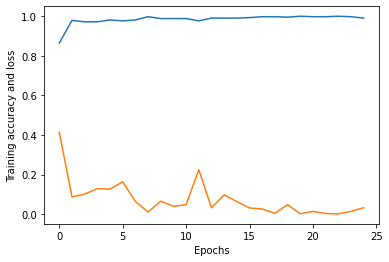

Text(0, 0.5, 'Validation loss')

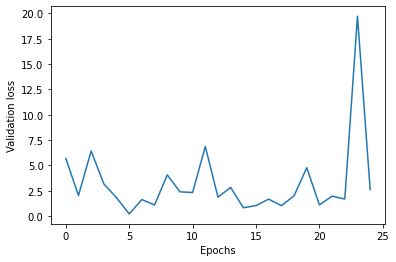

Text(0, 0.5, 'Validation accuracy')

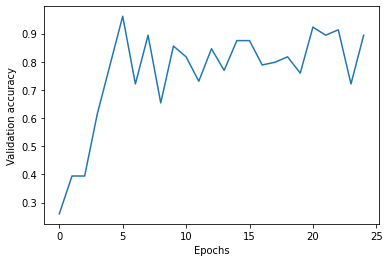

Found 40 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
10/10 [==============================] - 6s 629ms/step - loss: 4.2884 - accuracy: 0.8500
Accuracy Test : 0.8500000238418579


Test Accuracy: 0.85


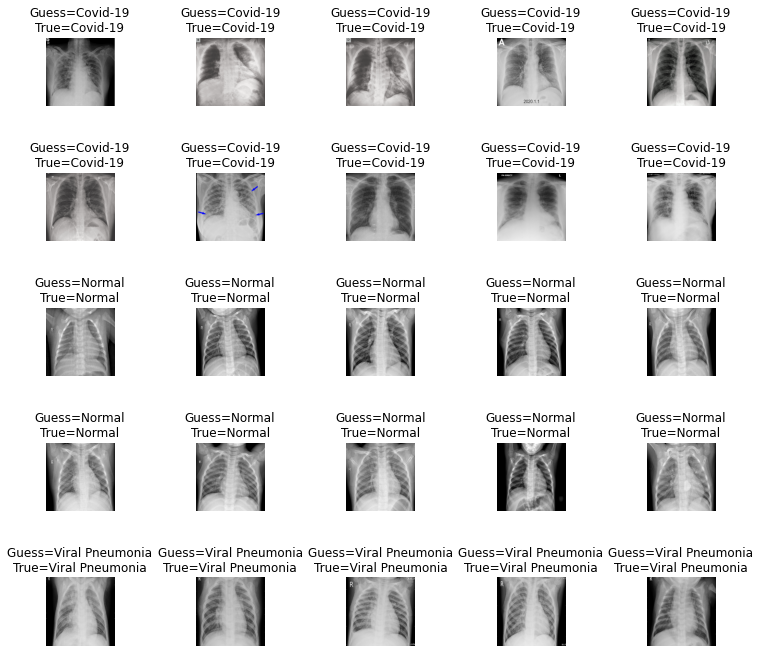

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.83      1.00      0.91        10
           2       1.00      0.50      0.67        10
           3       0.82      0.90      0.86        10

    accuracy                           0.85        40
   macro avg       0.87      0.85      0.84        40
weighted avg       0.87      0.85      0.84        40



Text(0.5, 1.0, 'Confusion_matrix')

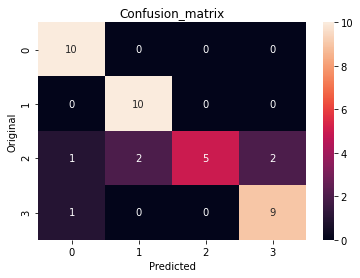

# EXCELLENT JOB! YOU SHOULD BE PROUD OF YOUR NEWLY ACQUIRED SKILLS